In [ ]:

# %pip install -q --upgrade langchain langchain-openai langgraph pandas matplotlib


In [ ]:

import os
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Optional, Type, TypedDict

from langchain_core.pydantic_v1 import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain.tools import BaseTool
from langchain.agents import AgentExecutor, create_openai_tools_agent

from langgraph.graph import StateGraph, END


# Set OpenAI API Key
os.environ["OPENAI_API_KEY"] = "open-api-key"  # API key

if not os.getenv("OPENAI_API_KEY"):
    print("OPENAI_API_KEY is not set in your environment.")
else:
    print("OPENAI_API_KEY found.")


OPENAI_API_KEY found.


In [12]:

class AgentState(TypedDict):
    messages: List[BaseMessage]


In [13]:

# --- LoadDataTool ---
class LoadDataArgs(BaseModel):
    file_path: str = Field(..., description="Path to the CSV file to load")

class LoadDataTool(BaseTool):
    name: str = "load_data"
    description: str = "Load a CSV file into memory for analysis"
    args_schema: Type[LoadDataArgs] = LoadDataArgs
    df: Optional[pd.DataFrame] = None

    def _run(self, file_path: str) -> str:
        try:
            self.df = pd.read_csv(file_path)
            return f"Loaded {len(self.df)} rows x {len(self.df.columns)} columns from {file_path}."
        except Exception as e:
            return f"Failed to load CSV: {e}"
    
    async def _arun(self, file_path: str) -> str:
        return self._run(file_path)


In [14]:

# --- AnalyzeDataTool ---
class AnalyzeDataArgs(BaseModel):
    query: str = Field(..., description="Simple analysis instruction, e.g., 'head(5)' or 'describe()'")

class AnalyzeDataTool(BaseTool):
    name: str = "analyze_data"
    description: str = "Analyze the loaded DataFrame: head(n), describe(), columns, value_counts(col), top_by(col, n)"
    args_schema: Type[AnalyzeDataArgs] = AnalyzeDataArgs

    load_tool: Optional[LoadDataTool] = None

    @classmethod
    def from_load_tool(cls, load_tool: "LoadDataTool") -> "AnalyzeDataTool":
        tool = cls()
        tool.load_tool = load_tool
        return tool

    def _run(self, query: str) -> str:
        if self.load_tool is None or self.load_tool.df is None:
            return "No data loaded. Use load_data first."
        df = self.load_tool.df
        try:
            q = query.strip().lower()
            if q.startswith("head(") and q.endswith(")"):
                n = int(q[len("head("):-1])
                return df.head(n).to_string(index=False)
            if q == "head":
                return df.head(5).to_string(index=False)
            if q in ("describe()", "describe"):
                return df.describe(include='all').to_string()
            if q == "columns":
                return ", ".join(map(str, df.columns.tolist()))
            if q.startswith("value_counts(") and q.endswith(")"):
                col = q[len("value_counts("):-1].strip()
                if col not in df.columns:
                    return f"Column '{col}' not found."
                return df[col].value_counts().to_string()
            if q.startswith("top_by(") and q.endswith(")"):
                inside = q[len("top_by("):-1]
                parts = [p.strip() for p in inside.split(",")]
                if len(parts) != 2:
                    return "Use: top_by(col, n)"
                col, n = parts[0], int(parts[1])
                if col not in df.columns:
                    return f"Column '{col}' not found."
                return df.nlargest(n, col).to_string(index=False)
            return "Unknown query. Try: head, head(n), describe(), columns, value_counts(col), top_by(col, n)."
        except Exception as e:
            return f"Analyze error: {e}"
    
    async def _arun(self, query: str) -> str:
        return self._run(query)


In [15]:

# --- PlotDataTool ---
class PlotDataArgs(BaseModel):
    command: str = Field(..., description="Format: 'plot_type, x_col, y_col, title' where plot_type in {line, bar, scatter}")

class PlotDataTool(BaseTool):
    name: str = "plot_data"
    description: str = "Create a matplotlib chart from the loaded DataFrame"
    args_schema: Type[PlotDataArgs] = PlotDataArgs

    load_tool: Optional[LoadDataTool] = None

    @classmethod
    def from_load_tool(cls, load_tool: "LoadDataTool") -> "PlotDataTool":
        tool = cls()
        tool.load_tool = load_tool
        return tool

    def _run(self, command: str) -> str:
        if self.load_tool is None or self.load_tool.df is None:
            return "No data loaded. Use load_data first."
        df = self.load_tool.df
        parts = [p.strip() for p in command.split(",")]
        if len(parts) != 4:
            return "Use: 'plot_type, x_col, y_col, title'"
        plot_type, x, y, title = parts
        if x not in df.columns or y not in df.columns:
            return f"Columns '{x}' or '{y}' not found. Available: {', '.join(df.columns)}"
        try:
            plt.figure()
            if plot_type == "line":
                plt.plot(df[x], df[y])
            elif plot_type == "bar":
                plt.bar(df[x], df[y])
            elif plot_type == "scatter":
                plt.scatter(df[x], df[y])
            else:
                return "plot_type must be one of: line, bar, scatter"
            plt.xlabel(x)
            plt.ylabel(y)
            plt.title(title)
            plt.show()
            return "Plot created."
        except Exception as e:
            return f"Plot error: {e}"
    
    async def _arun(self, command: str) -> str:
        return self._run(command)


In [16]:

# Instantiate tools
load_tool = LoadDataTool()
analyze_tool = AnalyzeDataTool.from_load_tool(load_tool)
plot_tool = PlotDataTool.from_load_tool(load_tool)
tools = [load_tool, analyze_tool, plot_tool]

# LLM & Prompt with placeholders
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful data analysis assistant. Use tools when needed. Be concise and actionable."),
    MessagesPlaceholder("chat_history"),
    ("human", "{input}"),
    MessagesPlaceholder("agent_scratchpad"),
])

agent = create_openai_tools_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, handle_parsing_errors=True)
print("Agent initialized")


Agent initialized


In [17]:

def agent_node(state: AgentState) -> AgentState:
    msgs = state["messages"]
    if not msgs:
        return state
    last = msgs[-1]
    if not isinstance(last, HumanMessage):
        last = HumanMessage(content=getattr(last, "content", str(last)))
    chat_history = msgs[:-1]
    result = agent_executor.invoke({"input": last.content, "chat_history": chat_history})
    output_text = result.get("output") or result.get("output_text") or str(result)
    state["messages"].append(AIMessage(content=output_text))
    return state

graph = StateGraph(AgentState)
graph.add_node("agent", agent_node)
graph.set_entry_point("agent")
graph.add_edge("agent", END)
app = graph.compile()
print("LangGraph compiled")


LangGraph compiled


In [18]:

def run_turn(user_text: str, history: Optional[List[BaseMessage]] = None) -> List[BaseMessage]:
    if history is None:
        history = []
    state: AgentState = {"messages": history + [HumanMessage(content=user_text)]}
    out = app.invoke(state)
    return out["messages"]


In [ ]:

#demo CSV
# toy_path = "sample.csv"
# toy_df = pd.DataFrame({
#     "month": ["Jan","Feb","Mar","Apr","May","Jun"],
#     "revenue": [1200, 1500, 1600, 900, 1800, 2100],
#     "units": [120, 140, 150, 90, 175, 195]
# })
# toy_df.to_csv(toy_path, index=False)
# toy_df.head()


,month,revenue,units
0,Jan,1200,120
1,Feb,1500,140
2,Mar,1600,150
3,Apr,900,90
4,May,1800,175


 Chat ready. Type your message. Type 'quit' to stop.
Human: Load the dataset
Assistant: Please provide the path to the CSV file you would like to load.

Human: sample_sales.csv
Assistant: The dataset has been successfully loaded, containing 10 rows and 5 columns. How would you like to proceed with the analysis?

Human: describe the dataset
Assistant: Here is the summary of the dataset:

- **Date**: 10 entries, with 5 unique dates. The most frequent date is "2024-01-01" (2 occurrences).
- **Product**: 10 entries, with 5 unique products. The most frequent product is "Laptop" (3 occurrences).
- **Category**: 10 entries, with 2 unique categories. The most frequent category is "Electronics" (5 occurrences).
- **Quantity**: 
  - Mean: 7.3
  - Standard Deviation: 3.59
  - Minimum: 3
  - Maximum: 15
- **Revenue**: 
  - Mean: 4010.00
  - Standard Deviation: 2345.42
  - Minimum: 1500.00
  - Maximum: 7500.00

If you need further analysis or visualizations, let me know!

Human: Plot the some graph

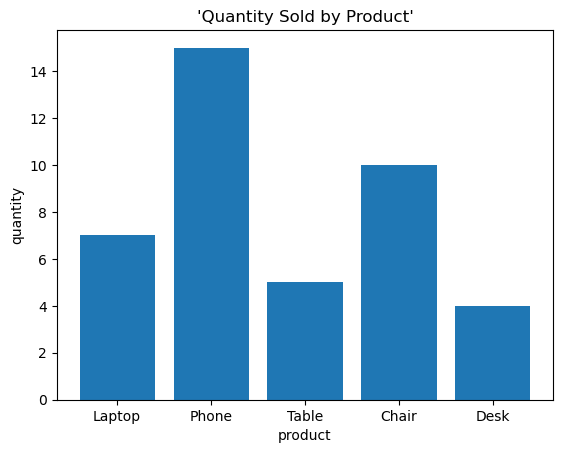

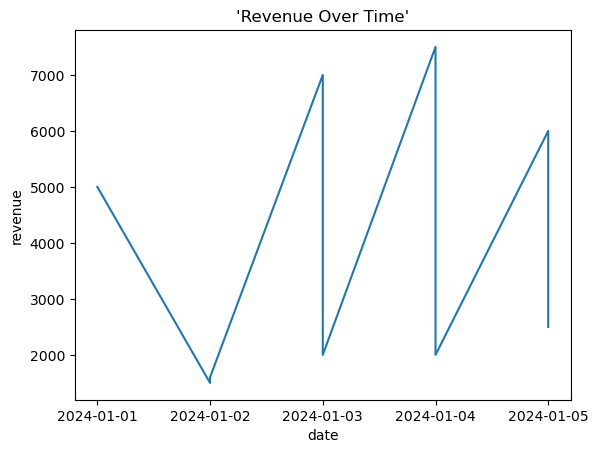

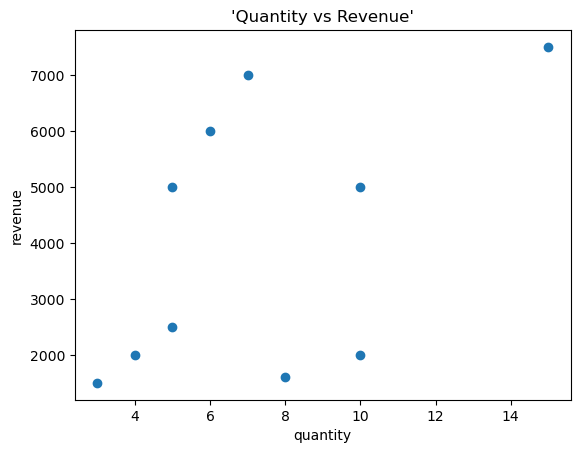

Assistant: The following graphs have been created for better understanding of the dataset:

1. **Quantity Sold by Product**: A bar chart showing the quantity sold for each product.
2. **Revenue Over Time**: A line chart displaying revenue trends over the specified dates.
3. **Quantity vs Revenue**: A scatter plot illustrating the relationship between quantity sold and revenue generated.

If you need further analysis or specific insights from these graphs, let me know!

Human: what can you make it out from dataset?
Assistant: From the dataset, we can derive several insights:

1. **Product Performance**:
   - The "Laptop" product has the highest sales volume, indicating it is a popular choice among customers.
   - Other products may need marketing efforts to boost their sales.

2. **Revenue Insights**:
   - The average revenue is relatively high, suggesting that the products sold are priced well, or that higher-priced items are being sold.
   - There are significant variations in revenue

In [ ]:

# Continuous chat loop stop with 'quit' / 'exit' / 'q'
def chat_loop(quit_words=("quit","exit","q")):
    print("Chat ready. Type your message. Type 'quit' to stop.")
    history: List[BaseMessage] = []
    while True:
        try:
            user = input("You: ").strip()
            print("Human: " + user )
        except (EOFError, KeyboardInterrupt):
            print("\nExiting chat.")
            break
        if user.lower() in quit_words:
            print("Exiting chat.")
            break
        history = run_turn(user, history)
        # Print last assistant message
        reply = history[-1].content if history and hasattr(history[-1], "content") else "(no reply)"
        print(f"Assistant: {reply}\n")

# Start the conversation
chat_loop()
